In [89]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime
from utils_tensorflow import *

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ticker = 'AAPL'
HISTORY_START_DATE = '2012-01-01'

df = si.get_data(ticker)
df = df[df.index >= HISTORY_START_DATE]
df['adjclose'].dropna(inplace=True)

In [147]:
ticker = '^GSPC' # ^GSPC is S&P 500 ticker
HISTORY_START_DATE = '2012-01-01'

df = si.get_data(ticker)
df = df[df.index >= HISTORY_START_DATE]
df['adjclose'].dropna(inplace=True)
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-05-22,2948.050049,2956.760010,2933.590088,2955.449951,2955.449951,3952800000,^GSPC
2020-05-26,3004.080078,3021.719971,2988.169922,2991.770020,2991.770020,5837060000,^GSPC
2020-05-27,3015.649902,3036.250000,2969.750000,3036.129883,3036.129883,6371230000,^GSPC
2020-05-28,3046.610107,3068.669922,3023.399902,3029.729980,3029.729980,5402670000,^GSPC
2020-05-29,3025.169922,3049.169922,2998.610107,3044.310059,3044.310059,7275080000,^GSPC


In [148]:
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-05-22,2948.050049,2956.760010,2933.590088,2955.449951,2955.449951,3952800000,^GSPC
2020-05-26,3004.080078,3021.719971,2988.169922,2991.770020,2991.770020,5837060000,^GSPC
2020-05-27,3015.649902,3036.250000,2969.750000,3036.129883,3036.129883,6371230000,^GSPC
2020-05-28,3046.610107,3068.669922,3023.399902,3029.729980,3029.729980,5402670000,^GSPC
2020-05-29,3025.169922,3049.169922,2998.610107,3044.310059,3044.310059,7275080000,^GSPC


In [149]:
df.shape

(2115, 7)

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018FF78C46A0>],
      dtype=object)

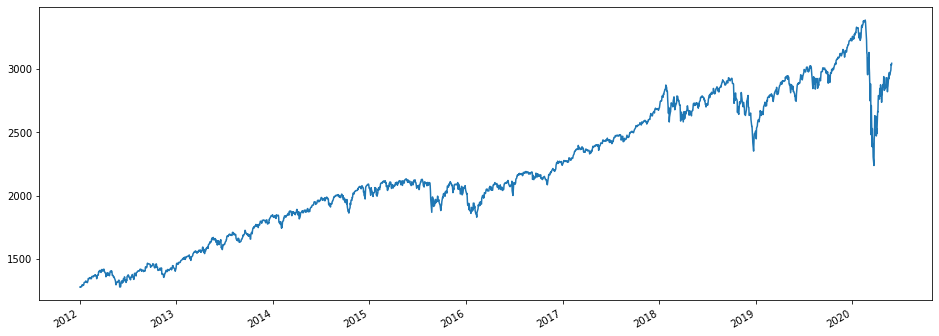

In [150]:
df['adjclose'].plot(subplots=True)

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [151]:
features_considered = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

In [152]:
features = df[df['open'].isna()==False][features_considered]
features = features[features.index > '2012-01-01']
features.head()

,open,high,low,close,adjclose,volume
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018F88E01B00>,
      dtype=object)

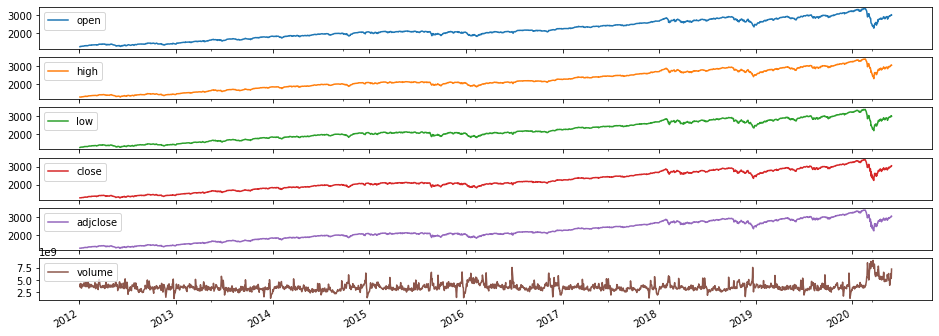

In [153]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [154]:
data_scaled = features.copy()

TRAIN_SPLIT = int(df.shape[0] * 0.75)
print(f"TRAIN_SPLIT: {TRAIN_SPLIT}, TEST SPLIT: {df.shape[0] - TRAIN_SPLIT}")

column_scaler = {}
# scale the data (prices) from 0 to 1
for column in data_scaled.columns:
    
    column_values = data_scaled[column].values.reshape(-1, 1)
    # Fit only on training data
    scaler = MinMaxScaler()
    scaler.fit(column_values[:TRAIN_SPLIT])
    data_scaled[column] = scaler.transform(column_values)
    column_scaler[column] = scaler

data_scaled.tail()

TRAIN_SPLIT: 1586, TEST SPLIT: 529


,open,high,low,close,adjclose,volume
2020-05-22,1.050250,1.052624,1.051557,1.051748,1.051748,0.425903
2020-05-26,1.085086,1.093373,1.085827,1.074508,1.074508,0.722707
2020-05-27,1.092280,1.102488,1.074261,1.102305,1.102305,0.806849
2020-05-28,1.111529,1.122825,1.107948,1.098295,1.098295,0.654283
2020-05-29,1.098199,1.110592,1.092382,1.107431,1.107431,0.949221


### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [155]:
dataset.shape[0]

2115

In [156]:
TEST_SPLIT = dataset.shape

In [157]:
target_variable = 'adjclose'
target_var_index = data_scaled.columns.tolist().index(target_variable)

target = data_scaled[target_variable].values
dataset = data_scaled.values

past_history = 30
future_target = 7
BATCH_SIZE = 64
BUFFER_SIZE = 1000

TEST_SPLIT = dataset.shape[0] - 1 - past_history

train_data = prepare_batches(dataset, target,
                             0, TRAIN_SPLIT,
                             past_history, future_target)
val_data = prepare_batches(dataset, target,
                           TRAIN_SPLIT, TEST_SPLIT,
                           past_history, future_target)

test_data = prepare_test_batch(dataset, TEST_SPLIT, None,  past_history)

In [158]:
test_dates = prepare_dates(dates, TEST_SPLIT, 2108, 
                          past_history, future_target)

Let's check out a sample data-point.

In [159]:
dates = data_scaled[data_scaled.index > HISTORY_START_DATE].index
dates = np.array(dates.date, 'str')

train_dates = prepare_dates(dates, 0, TRAIN_SPLIT, 
                            past_history, future_target)

val_dates = prepare_dates(dates, TRAIN_SPLIT, TEST_SPLIT, 
                          past_history, future_target)

test_dates = prepare_dates(dates, TEST_SPLIT, 2108, 
                          past_history, future_target)

In [160]:
# print ('Single window of past history : {}'.format(x_train_multi[0].shape))
# print ('Target to predict : {}'.format(y_train_multi[0].shape))

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

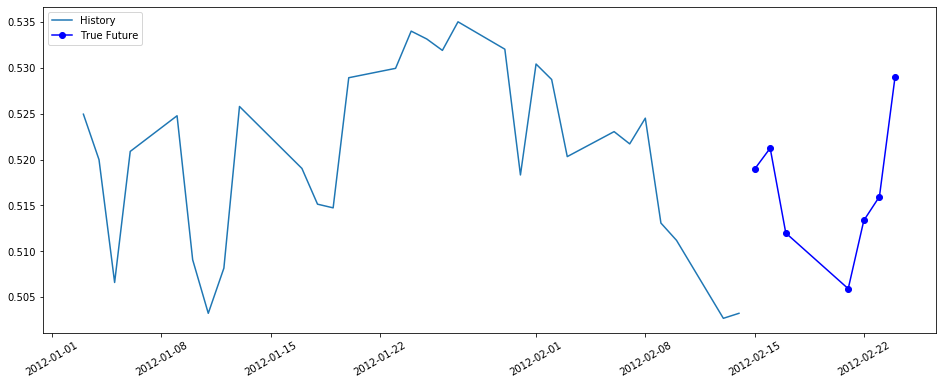

In [161]:
for xy, date in zip(train_data.take(1), train_dates.take(1)):
    
    x, y = xy
#     print(x[0].numpy())
    x_dates, y_dates = date
    history = np.array(x[0])[:, target_var_index]
    true_future = np.array(y[0])
#     print(history)
    
    multi_step_plot_dates(x_dates[0].numpy(), history, y_dates[0].numpy(), true_future)

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [162]:
input_shape = (past_history, len(features_considered))

In [163]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=input_shape))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

# multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.compile(optimizer='adam', loss='mae')

Let's see how the model predicts before it trains.

In [164]:
for x, y in val_data.take(1):
    print(multi_step_model.predict(x).shape)

(64, 7)


In [165]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

multi_step_history = multi_step_model.fit(train_data, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=val_data,
                                          validation_steps=50,
                                          callbacks=[early_stopping])

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 9s 46ms/step - loss: 0.0787 - val_loss: 0.0496
Epoch 2/10
200/200 [==============================] - 6s 28ms/step - loss: 0.0187 - val_loss: 0.0432
Epoch 3/10
200/200 [==============================] - 6s 29ms/step - loss: 0.0176 - val_loss: 0.0422
Epoch 4/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0169 - val_loss: 0.0501
Epoch 5/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0166 - val_loss: 0.0378
Epoch 6/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0160 - val_loss: 0.0379
Epoch 7/10
200/200 [==============================] - 6s 29ms/step - loss: 0.0158 - val_loss: 0.0362
Epoch 8/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0154 - val_loss: 0.0428
Epoch 9/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0151 - val_loss: 0.0406
Epoch 10/10
200/200 [===========================

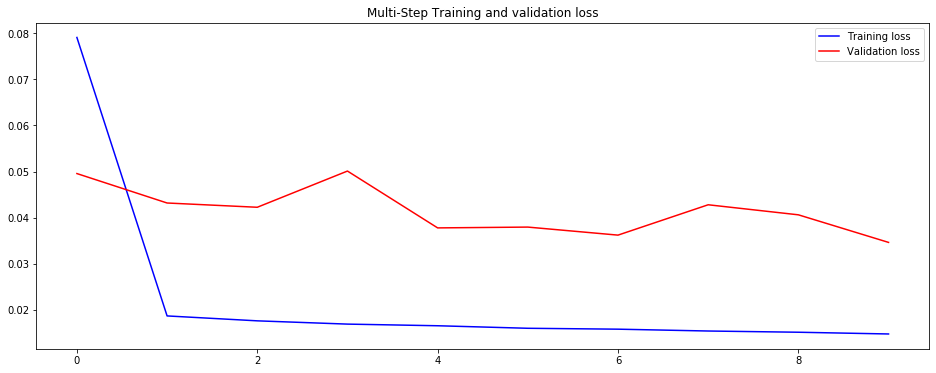

In [166]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

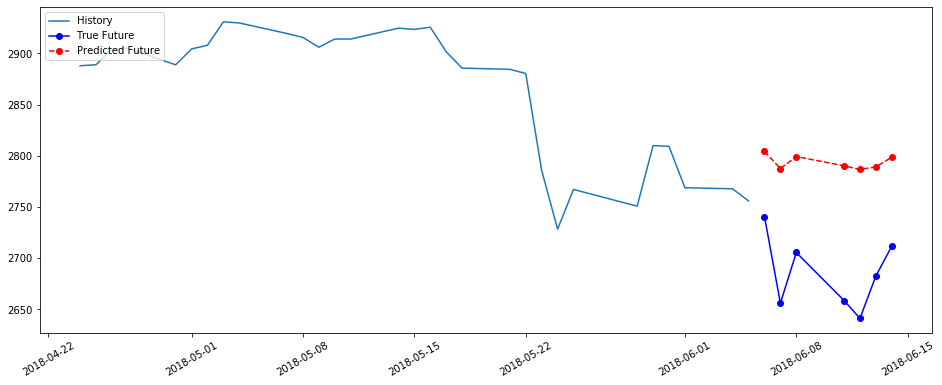

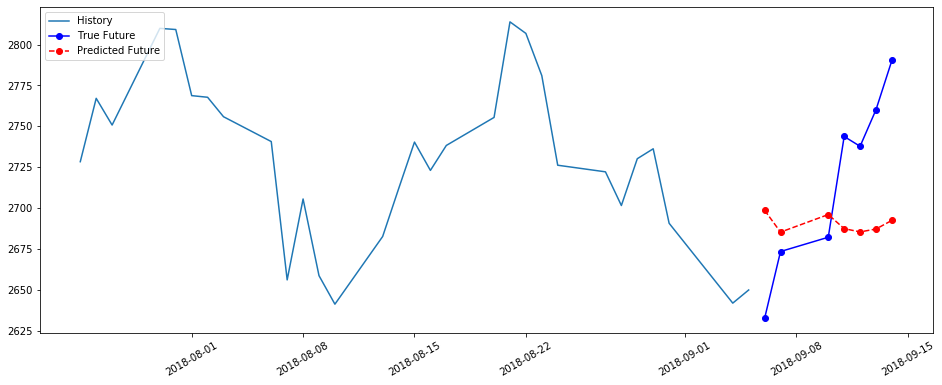

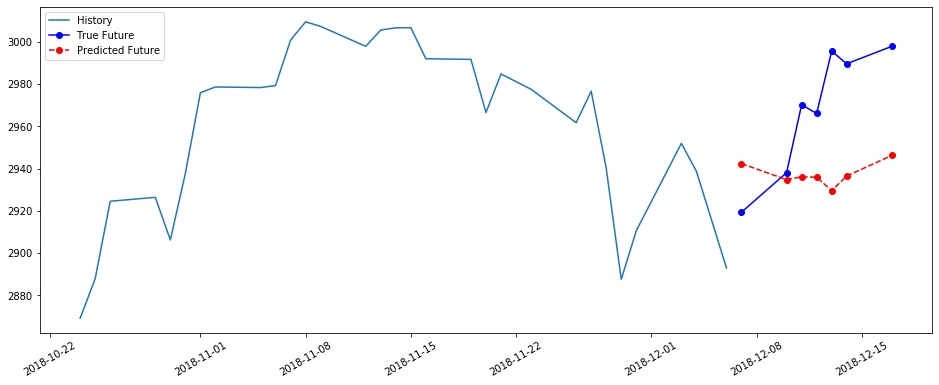

In [167]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
#     print(x[0])
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = multi_step_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

In [168]:
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-05-22,2948.050049,2956.760010,2933.590088,2955.449951,2955.449951,3952800000,^GSPC
2020-05-26,3004.080078,3021.719971,2988.169922,2991.770020,2991.770020,5837060000,^GSPC
2020-05-27,3015.649902,3036.250000,2969.750000,3036.129883,3036.129883,6371230000,^GSPC
2020-05-28,3046.610107,3068.669922,3023.399902,3029.729980,3029.729980,5402670000,^GSPC
2020-05-29,3025.169922,3049.169922,2998.610107,3044.310059,3044.310059,7275080000,^GSPC


In [169]:
for x, date in zip(test_data.take(1), test_dates.take(1)):
    
    x = xy
    x_dates, y_dates = date
#     print(x[0])
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
#     true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = multi_step_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(),
                          prediction_rescaled)

In [124]:
pd.DatetimeIndex([i.decode("utf-8") for i in x_dates[0].numpy().flatten()])

DatetimeIndex(['2020-04-03', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
               '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
               '2020-05-08', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15'],
              dtype='datetime64[ns]', freq=None)

In [111]:
pd.DatetimeIndex(x_dates[0].numpy().flatten())

TypeError: <class 'bytes'> is not convertible to datetime